In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mouse_neuropixel_export.analysis import sync, var
from mouse_neuropixel_export.schemas import metadata, experiment, ephys, area_map, stimulus

# Point schemas to match your directory structure

This data export uses the in-house package `enty` to access the underlying files.

First we need to point the `enty` schemas to where the exported data sits. 

Inside the exported directory `mouse_neuropixel_export` should be a directory called `schemas`.

Update the `schema_dir` variable in the cell below to the correct path for your system.

In [2]:
schema_dir = '/mnt/at-export01/mouse_neuropixel_export/schemas/'

metadata.base_dir = schema_dir + 'metadata'
experiment.base_dir = schema_dir + 'experiment'
ephys.base_dir = schema_dir + 'ephys'
area_map.base_dir = schema_dir + 'area_map'
stimulus.base_dir = schema_dir + 'stimulus'

# Get available scans

First we use the metadata schema to see the available exported scans. The keys are saved in the `all_keys` variable. 

In [3]:
all_keys = []
for _, row in metadata.ScanStimKey().iterrows():
    all_keys.append(dict(row))

print(f'There are {len(all_keys)} available scans.')

There are 20 available scans.


# Select key

Now we select a single key for this demo. The attributes in the key contain the scan and stimulus information needed to get the corresponding data.

In [4]:
key = all_keys[15]
key

{'animal_id': 29189,
 'session': 16,
 'scan_idx': 1,
 'collection_id': 7,
 'image_class': 'imagenet'}

# Access data for a given key

Data about the exeriment can be found in the `experiment` schema, equivalent to the `pipeline_experiment` schema in our `datajoint` database.

Data from the ephys pipeline including individual unit spike times is found in the `ephys` schema.

Data for the area mapping is found in the `area_map` schema.

Data to reconstruct the stimulus and align to neural traces is found in the `stimulus` schema.

## Experiment data

To access the data for a given key, use the `get()` method on the desired schema table. For the session data, see the cell below. 

In this case, the returned data is a pandas dataframe.

In [5]:
session_df = experiment.Session(**key).get()
session_df

,animal_id,session,rig,session_date,username,anesthesia,scan_path,behavior_path,craniotomy_notes,session_notes,archive,session_ts
0,29189,16,RS1,2023-05-18,maria,awake,W:\Two-Photon\maria\2023-05-18_12-53-16,W:\Two-Photon\maria\2023-05-18_12-53-16,,,RS1A2A,2023-05-18 10:53:16


## Ephys data

The neural traces for each scan can be found in the `ephys.CuratedClustering`

In [6]:
unit_df = ephys.CuratedClustering(**key).get()
spike_times = np.array(unit_df['spike_times'], dtype='object')
print(f'There are {len(spike_times)} units for this key')

There are 547 units for this key


## Area data

To get the area labels for each unit use the `area_map` schema.

In [7]:
area_per_unit_df = area_map.AreaPerUnit(**key).get()
area_per_unit_df

,animal_id,session,scan_idx,inc_id,paramset_id,curation_id,unit_id,rf_method,channel,depth,area,data_key
0,29189,16,1,51,2,1,0,1,4,60,P,29189-16-1
1,29189,16,1,51,2,1,1,1,2,40,unassigned,29189-16-1
2,29189,16,1,51,2,1,2,1,2,40,unassigned,29189-16-1
3,29189,16,1,51,2,1,3,1,0,20,unassigned,29189-16-1
4,29189,16,1,51,2,1,4,1,0,20,unassigned,29189-16-1
...,...,...,...,...,...,...,...,...,...,...,...,...
542,29189,16,1,51,2,1,634,1,186,1880,V1,29189-16-1
543,29189,16,1,51,2,1,635,1,186,1880,V1,29189-16-1
544,29189,16,1,51,2,1,636,1,186,1880,V1,29189-16-1
545,29189,16,1,51,2,1,637,1,191,1920,out,29189-16-1


## Stimulus data

The information needed to sync the spike times to the stimulus is in `stimulus.EphysSync`

Perform the sync:

In [8]:
sync_df = stimulus.EphysSync(**key).get()
sync_info = sync_df.to_dict(orient='records')[0]
sync_info['npixel_samples'] = np.arange(sync_info['num_npixel_samples'])
npx_synced_times = sync.npixel_samples_in_stimulus_clock(**sync_info)
spike_times_synced = spike_times + npx_synced_times[0]

### Get trial information

The data for each experimental trial is in `stimulus.Trial`.

Get the trial data:

In [9]:
trial_df = stimulus.Trial(**key).get()
trial_df

,animal_id,session,scan_idx,trial_idx,condition_hash,flip_times,last_flip,trial_ts
0,29189,16,1,0,S9O/DyFEjJlEzXWa5ROy,"[[1684432505.5321646, 1684432505.6488283, 1684...",3,2023-05-18 10:55:06
1,29189,16,1,1,dFr6LDrWDHZuSHpZtY/A,"[[1684432506.3154716, 1684432506.515467, 16844...",6,2023-05-18 10:55:07
2,29189,16,1,2,A8xhmoEN4jr3px79uVmv,"[[1684432507.1321104, 1684432507.282108, 16844...",9,2023-05-18 10:55:07
3,29189,16,1,3,ZS7g0bMXRZa1wEaMRU3U,"[[1684432507.865422, 1684432507.9820857, 16844...",12,2023-05-18 10:55:08
4,29189,16,1,4,5BErLsxwfMQ77EUxpjQW,"[[1684432508.5987294, 1684432508.7153924, 1684...",15,2023-05-18 10:55:09
...,...,...,...,...,...,...,...,...
5995,29189,16,1,5995,dKylC4Qz7L3cigL1/tTj,"[[1684436898.766177, 1684436898.949503, 168443...",17988,2023-05-18 12:08:19
5996,29189,16,1,5996,A4+fDLjwE0aay+sCS17m,"[[1684436899.5161521, 1684436899.6661475, 1684...",17991,2023-05-18 12:08:20
5997,29189,16,1,5997,o8Mrj+DqfPItdt2VfUQa,"[[1684436900.2327943, 1684436900.3827877, 1684...",17994,2023-05-18 12:08:20
5998,29189,16,1,5998,8qZN/8Tma/RSpbA+r0QL,"[[1684436900.9494374, 1684436901.1160984, 1684...",17997,2023-05-18 12:08:21


### Get stimulus image flip times

The synced spike times are in the same clock as the trial information in `stimulus.Trial`

The `flip_times` column contains the timestamps for the stimulus image presentations. 

Each trial has three flip times that correspond to:

1. start of trial and blank period
2. start of image presentation
3. end of image presentation and trial

Below we get the flip times for a single trial, by restricting the dataframe to a single row using the `trial_idx` attribute:

In [10]:
trial_idx = 0
single_trial_flip_times = trial_df[trial_df['trial_idx'] == trial_idx]['flip_times'].values.item().squeeze() # get the flip times for this trial

print(
    f"""
    start of trial and blank period:         {single_trial_flip_times[0]}
    start of image presentation:             {single_trial_flip_times[1]}
    end of image presentation and trial:     {single_trial_flip_times[2]}
    """
)


    start of trial and blank period:         1684432505.5321646
    start of image presentation:             1684432505.6488283
    end of image presentation and trial:     1684432506.165479
    


### Get single vs oracle trials

`Single` trials are trials where a given image is shown one time during the session.

`Oracle` trials are trials with images repeated 10 times during the session.

To determine which trials are oracle trials, check how many times the `condition_hash` is repeated across trials in the `stimulus.Trial` table.

In [11]:
repeat_df = trial_df.groupby('condition_hash', as_index=False)['trial_idx'].count().rename(columns={'trial_idx': 'n_repeats'})
repeat_df

,condition_hash,n_repeats
0,++xcBo77hxkuTL2dPq/t,1
1,+/k9lGMQLDWipvuS/ZGx,1
2,+/nSZDnvoV+UKV99V+cV,1
3,+0K7jS8y4fbkhLiMSk8k,1
4,+1PSx+OcnMlPBfxnVhVh,1
...,...,...
5095,zwHeIlSKDyj+51qziemE,1
5096,zwYQysONNyvEJCbacsSS,1
5097,zxf0qL9cfOWZYV5ShGVK,1
5098,zy3UTUj/ldZZTq+0pF2R,1


To get all of the single trial conditions, restrict such that `n_repeats` is 1:

In [12]:
single_condition_hash_df = repeat_df[repeat_df.n_repeats == 1]
single_condition_hash_df

,condition_hash,n_repeats
0,++xcBo77hxkuTL2dPq/t,1
1,+/k9lGMQLDWipvuS/ZGx,1
2,+/nSZDnvoV+UKV99V+cV,1
3,+0K7jS8y4fbkhLiMSk8k,1
4,+1PSx+OcnMlPBfxnVhVh,1
...,...,...
5095,zwHeIlSKDyj+51qziemE,1
5096,zwYQysONNyvEJCbacsSS,1
5097,zxf0qL9cfOWZYV5ShGVK,1
5098,zy3UTUj/ldZZTq+0pF2R,1


To get the oracle conditions, restrict such that `n_repeats` is 10:

In [13]:
oracle_condition_hash_df = repeat_df[repeat_df.n_repeats == 10]
oracle_condition_hash_df

,condition_hash,n_repeats
417,3mmwSf1O+EF6jSNHhPI5,10
534,5BErLsxwfMQ77EUxpjQW,10
545,5I67kmu9uL5iQXu56utC,10
568,5XBhkywYOvVHlco/C1qx,10
596,5vfRxsZ3YHE1sO0NmLYO,10
...,...,...
4851,wwp4M8BvmH8wbB5V5FOJ,10
4889,xQbxa2oW1fLAyxgmSyHG,10
4924,xpXPyGsiEuMttsuxjF7Q,10
4938,xyQRyuwVLk7P3L2vVMSn,10


These can be mapped back to the `stimulus.Trial` table:

In [14]:
single_trial_df = trial_df[trial_df.condition_hash.isin(single_condition_hash_df.condition_hash)]
single_trial_df

,animal_id,session,scan_idx,trial_idx,condition_hash,flip_times,last_flip,trial_ts
0,29189,16,1,0,S9O/DyFEjJlEzXWa5ROy,"[[1684432505.5321646, 1684432505.6488283, 1684...",3,2023-05-18 10:55:06
1,29189,16,1,1,dFr6LDrWDHZuSHpZtY/A,"[[1684432506.3154716, 1684432506.515467, 16844...",6,2023-05-18 10:55:07
2,29189,16,1,2,A8xhmoEN4jr3px79uVmv,"[[1684432507.1321104, 1684432507.282108, 16844...",9,2023-05-18 10:55:07
6,29189,16,1,6,QAiVqC+8SPnpLklMXRPN,"[[1684432510.0486836, 1684432510.1653461, 1684...",21,2023-05-18 10:55:10
7,29189,16,1,7,Ca+1uTJYFJt0objMH4Es,"[[1684432510.7319949, 1684432510.8986554, 1684...",24,2023-05-18 10:55:11
...,...,...,...,...,...,...,...,...
5994,29189,16,1,5994,vDg5nA4ZKLINcgjOFthf,"[[1684436898.0495353, 1684436898.199531, 16844...",17985,2023-05-18 12:08:18
5996,29189,16,1,5996,A4+fDLjwE0aay+sCS17m,"[[1684436899.5161521, 1684436899.6661475, 1684...",17991,2023-05-18 12:08:20
5997,29189,16,1,5997,o8Mrj+DqfPItdt2VfUQa,"[[1684436900.2327943, 1684436900.3827877, 1684...",17994,2023-05-18 12:08:20
5998,29189,16,1,5998,8qZN/8Tma/RSpbA+r0QL,"[[1684436900.9494374, 1684436901.1160984, 1684...",17997,2023-05-18 12:08:21


In [15]:
oracle_trial_df = trial_df[trial_df.condition_hash.isin(oracle_condition_hash_df.condition_hash)]
oracle_trial_df

,animal_id,session,scan_idx,trial_idx,condition_hash,flip_times,last_flip,trial_ts
3,29189,16,1,3,ZS7g0bMXRZa1wEaMRU3U,"[[1684432507.865422, 1684432507.9820857, 16844...",12,2023-05-18 10:55:08
4,29189,16,1,4,5BErLsxwfMQ77EUxpjQW,"[[1684432508.5987294, 1684432508.7153924, 1684...",15,2023-05-18 10:55:09
5,29189,16,1,5,Ksxd2PDvUTJNKyirtm6S,"[[1684432509.2987084, 1684432509.4820333, 1684...",18,2023-05-18 10:55:10
9,29189,16,1,9,wwp4M8BvmH8wbB5V5FOJ,"[[1684432512.1652808, 1684432512.2819436, 1684...",30,2023-05-18 10:55:12
10,29189,16,1,10,PCu6ZcWtapflMNUVQDh+,"[[1684432512.8652577, 1684432513.015251, 16844...",33,2023-05-18 10:55:13
...,...,...,...,...,...,...,...,...
5967,29189,16,1,5967,JGoEUUwsZmSMQ4dE2rTp,"[[1684436878.2835422, 1684436878.4002063, 1684...",17904,2023-05-18 12:07:58
5968,29189,16,1,5968,TFLSnbTdEXKPnXEp+t0O,"[[1684436878.9835181, 1684436879.1835108, 1684...",17907,2023-05-18 12:07:59
5987,29189,16,1,5987,of8gAXLKGqZV4Fvv/6Ap,"[[1684436892.8497117, 1684436892.9663768, 1684...",17964,2023-05-18 12:08:13
5990,29189,16,1,5990,SbUDXsB3GtVTA7aXAMGs,"[[1684436895.0663025, 1684436895.2329655, 1684...",17973,2023-05-18 12:08:15


### Get the stimulus image

To get to the actual image corresponding to the trial, an intermediate table is needed to map `condition_hash` to the `image_class` and `image_id` attributes which are needed to look up an image.

These intermediate tables depend on whether the trial is a `single` vs `oracle` trial.

For `single` trials, use `stimulus.ImageFrameInfo` and for `oracle` trials use `stimulus.ImageOracleFrameInfo`.

In [16]:
image_frame_info_df = stimulus.ImageFrameInfo(**key).get()
image_frame_info_df

,collection_id,image_class,image_id,condition_hash,pre_blank_period,presentation_time
0,7,imagenet,21748,bfywgHSwJeZaohGGGWwF,0.102591,0.5
1,7,imagenet,21748,eQfOeDUWTu77TjrPDfUu,0.305181,0.5
2,7,imagenet,21748,pcUKVIPSXQ/8LnqEiVUx,0.473661,0.5
3,7,imagenet,21748,S9goGuVBSjKLyHqVP46L,0.434856,0.5
4,7,imagenet,21749,+Qzx1etCzEUnTAHFvVlu,0.418676,0.5
...,...,...,...,...,...,...
20235,7,imagenet,26766,rxz0k8/yKfFNltBk2gli,0.367824,0.5
20236,7,imagenet,26767,/eBdOu58bliAcvxdk8YX,0.476672,0.5
20237,7,imagenet,26767,2QZy90kZvmWBJwh6XGsL,0.144623,0.5
20238,7,imagenet,26767,IDeifnhPmMuOlFp8rqPc,0.389246,0.5


In [17]:
image_oracle_frame_info_df = stimulus.ImageOracleFrameInfo(**key).get()
image_oracle_frame_info_df

,collection_id,image_class,image_id,condition_hash,pre_blank_period,presentation_time
0,7,imagenet,104,+bWafhD7SxNpnWhMZWCe,0.347088,0.5
1,7,imagenet,104,+NMYCCKOy+K3V80tDNVB,0.682911,0.5
2,7,imagenet,104,+VYpn3EIpAMRvoV/FXXQ,0.434368,0.5
3,7,imagenet,104,/2h/YtQpcJEQ8sxG7sLm,0.486107,0.5
4,7,imagenet,104,/5wkp9zt+0TrEzQXzCe7,0.493347,0.5
...,...,...,...,...,...,...
15068,7,imagenet,7495,zHQ6oFhi8d6CqD+xVdKA,0.469641,0.5
15069,7,imagenet,7495,ZlmZRZWitV2CBBny5DdC,0.427297,0.5
15070,7,imagenet,7495,zmG32j7TED9eMKE+5jeU,0.833075,0.5
15071,7,imagenet,7495,zOQF2btiiv5Jwg2abRbE,0.822549,0.5


Use the `image_class` and `image_id` values to create an `image_key` to identify a single image.

We can use that `image_key` to get the image.

Using the first row of `image_frame_info_df` as an example:

In [18]:
image_key = image_frame_info_df[['image_class', 'image_id']].iloc[0].to_dict()
image_key

{'image_class': 'imagenet', 'image_id': 21748}

Get the image from the table `stimulus.Image`:

In [19]:
image = stimulus.Image(**image_key).get()

Plot the image:

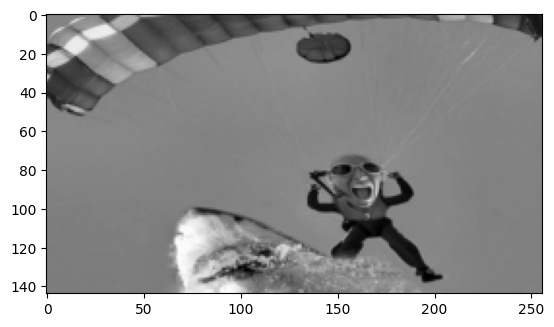

In [20]:
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

This can be done in the same way for oracle images, using `image_oracle_frame_info_df`:

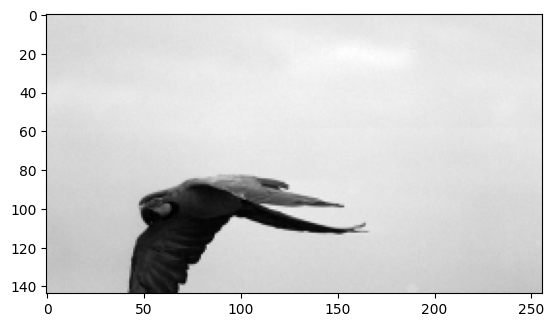

In [21]:
oracle_image_key = image_oracle_frame_info_df[['image_class', 'image_id']].iloc[0].to_dict()
oracle_image = stimulus.Image(**oracle_image_key).get()
fig, ax = plt.subplots()
ax.imshow(oracle_image, cmap='gray')

Additional information about the image can be found in `stimulus.ImageInfo` or `stimulus.ImageOracleInfo`. 

In [22]:
image_info_df = stimulus.ImageInfo(**key).get()
image_info_df

,collection_id,image_class,image_id,imagenet_id,description,frame_width,frame_height,num_channels
0,7,imagenet,21748,n03888257_31301,parachute,256,144,1
1,7,imagenet,21749,n03709823_12740,mailbag,256,144,1
2,7,imagenet,21750,n03658185_9598,letter_opener,256,144,1
3,7,imagenet,21751,n09835506_2015,ballplayer,256,144,1
4,7,imagenet,21752,n02123159_4376,tiger_cat,256,144,1
...,...,...,...,...,...,...,...,...
4995,7,imagenet,26763,n02963159_1802,cardigan,256,144,1
4996,7,imagenet,26764,n02860847_8339,bobsled,256,144,1
4997,7,imagenet,26765,n04204347_6731,shopping_cart,256,144,1
4998,7,imagenet,26766,n07873807_8370,pizza,256,144,1


In [23]:
image_oracle_info_df = stimulus.ImageOracleInfo(**key).get()
image_oracle_info_df

,collection_id,image_class,image_id,imagenet_id,description,frame_width,frame_height,num_channels
0,7,imagenet,104,n01818515_6993,macaw,256,144,1
1,7,imagenet,128,n02457408_567,three-toed_sloth,256,144,1
2,7,imagenet,183,n02704792_29207,amphibian,256,144,1
3,7,imagenet,355,n01871265_11585,tusker,256,144,1
4,7,imagenet,479,n02107908_8397,Appenzeller,256,144,1
...,...,...,...,...,...,...,...,...
95,7,imagenet,7107,n02011460_18927,bittern,256,144,1
96,7,imagenet,7119,n01981276_9899,king_crab,256,144,1
97,7,imagenet,7120,n01806143_11540,peacock,256,144,1
98,7,imagenet,7154,n02494079_1863,squirrel_monkey,256,144,1


Now use the `image_key` to get more information about the image:

In [24]:
image_info_df.merge(pd.DataFrame([image_key]))

,collection_id,image_class,image_id,imagenet_id,description,frame_width,frame_height,num_channels
0,7,imagenet,21748,n03888257_31301,parachute,256,144,1


Same for oracle:

In [25]:
image_oracle_info_df.merge(pd.DataFrame([oracle_image_key]))

,collection_id,image_class,image_id,imagenet_id,description,frame_width,frame_height,num_channels
0,7,imagenet,104,n01818515_6993,macaw,256,144,1


# Compute explainable variance

In this section, we use the oracle trials (trials with 10 repeats throughout the scan) to compute the explainable variance of the neural activity trace.

To do this we assemble a spike count array that has dimensions `n_oracle_images` x `n_repeats` x `n_units`.

- `n_oracle_images` comes from the number of unique condition hashes in `oracle_trial_df` that was computed earlier in the notebook.
- `n_repeats` comes from the number of repeats per oracle trial. Here it is assumed to be 10.
- `n_units` comes from the number of units in `unit_df` that was computed earlier in the notebook.

In [26]:
n_oracle_images = oracle_trial_df.condition_hash.nunique()
n_repeats = 10
n_units = len(unit_df)

In [27]:
spike_count_array = np.empty((n_oracle_images, n_repeats, n_units))
spike_count_array.shape

(100, 10, 547)

Now we fill the array by summing spike counts for each unit response trace for a given oracle image repeat:

In [28]:
for image_ind in range(n_oracle_images):
    # get the subset of trials per unique oracle image
    image_repeat_ind = image_ind * n_repeats
    condition_trial_df = oracle_trial_df.sort_values('condition_hash')[image_repeat_ind : image_repeat_ind + n_repeats]
    
    for repeat_ind in range(n_repeats):
        # get the flip times per image trial repeat
        trial_flip_times = condition_trial_df.iloc[repeat_ind].flip_times
        
        for unit_ind in range(n_units):
            # count spikes in given repeated oracle trial for each unit
            unit_spikes = spike_times_synced[unit_ind]
            spike_count_array[image_ind][repeat_ind][unit_ind] = len(unit_spikes[(unit_spikes >= trial_flip_times[0][1] + 0.05) & (unit_spikes <= trial_flip_times[0][2] + 0.05)])

Now we compute explainable variance on the array:

In [29]:
exp_var = var.compute_explainable_var(spike_count_array)

### Plot explainable variance

Text(0.5, 1.0, "{'animal_id': 29189, 'session': 16, 'scan_idx': 1, 'collection_id': 7, 'image_class': 'imagenet'} explainable var of all units")

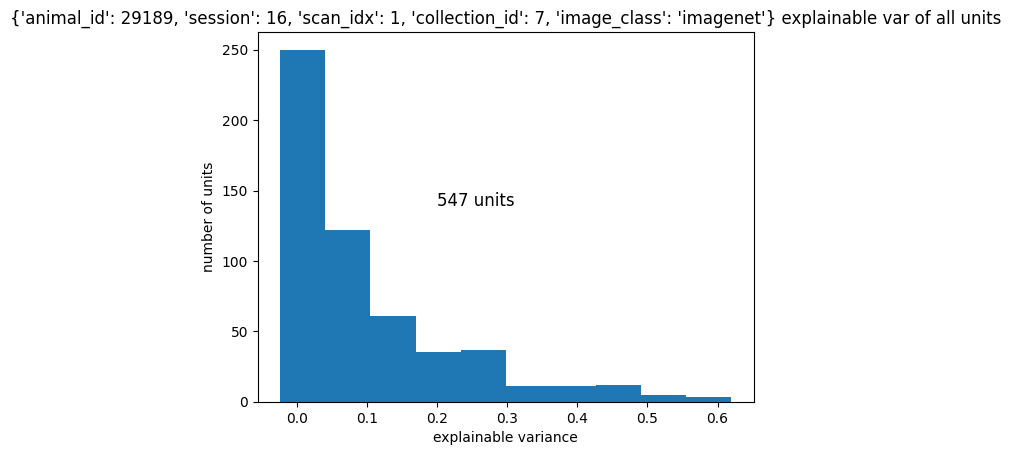

In [30]:
# all units 
fig, ax = plt.subplots()
ax.hist(exp_var)
ax.set_xlabel('explainable variance')
ax.set_ylabel('number of units')
ax.text(0.2, int(np.shape(spike_count_array)[2]/4), f'{np.shape(spike_count_array)[2]} units',  ha='left', va='bottom', fontsize = 12)
ax.set_title(f'{key} explainable var of all units')